In [1]:
#Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision 
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, ShiftScaleRotate)
from albumentations.pytorch import ToTensorV2
from torchsampler import ImbalancedDatasetSampler


from efficientnet_pytorch import EfficientNet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import GroupKFold, train_test_split

from PIL import Image
import os
import itertools
import gc
import warnings
import random
from tqdm import tqdm

import datetime
from timeit import default_timer as timer


In [2]:
#Lets set up some things
device = 'cuda:0' if torch.cuda.is_available() else torch.device("cpu")
device

'cuda:0'

In [3]:
warnings.simplefilter('ignore')
#Set up seeds 
SEED = 22

#Set up seeds from reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Lets first Load the data and take a look at it

In [4]:
#Lets load the train and test data
df = pd.read_csv('./data/train.csv')
train_dir = './data/jpeg/train/'


In [5]:
df['target'].value_counts()

target
0    32542
1      584
Name: count, dtype: int64

In [6]:
#Since we don't have labels for the test set in our data 
#Lets only use the train data and create traing and testing set by splitting it

X = df.drop(columns=['target'])
y = df['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED,stratify=y)
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)


Train DataFrame shape: (26500, 8)
Test DataFrame shape: (6626, 8)


In [7]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_8104064,IP_7207550,male,55.0,torso,unknown,benign,0
1,ISIC_6917587,IP_0894335,female,40.0,head/neck,unknown,benign,0
2,ISIC_3391651,IP_2842809,female,55.0,torso,unknown,benign,0
3,ISIC_4547675,IP_7279968,male,45.0,upper extremity,unknown,benign,0
4,ISIC_7289411,IP_5439716,male,70.0,torso,nevus,benign,0


In [8]:
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_0476762,IP_6323321,male,30.0,lower extremity,nevus,benign,0
1,ISIC_1560888,IP_9147454,female,55.0,upper extremity,unknown,benign,0
2,ISIC_1859923,IP_6420568,male,40.0,torso,unknown,benign,0
3,ISIC_9034411,IP_7517320,male,60.0,torso,unknown,benign,0
4,ISIC_5017874,IP_7517320,male,60.0,upper extremity,unknown,benign,0


We can see that there are around 33k images for train data and 10k images for test data.

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26500 entries, 0 to 26499
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     26500 non-null  object 
 1   patient_id                     26500 non-null  object 
 2   sex                            26449 non-null  object 
 3   age_approx                     26446 non-null  float64
 4   anatom_site_general_challenge  26084 non-null  object 
 5   diagnosis                      26500 non-null  object 
 6   benign_malignant               26500 non-null  object 
 7   target                         26500 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 1.6+ MB


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6626 entries, 0 to 6625
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     6626 non-null   object 
 1   patient_id                     6626 non-null   object 
 2   sex                            6612 non-null   object 
 3   age_approx                     6612 non-null   float64
 4   anatom_site_general_challenge  6515 non-null   object 
 5   diagnosis                      6626 non-null   object 
 6   benign_malignant               6626 non-null   object 
 7   target                         6626 non-null   int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 414.2+ KB


In [11]:
def plot_missing(df, data):
    missing_counts = df.isna().sum()
    missing_counts_df = pd.DataFrame(missing_counts, columns=['Null Values'])
    plt.figure(figsize=(10,6))
    sns.heatmap(missing_counts_df,cmap="YlGnBu",annot=True,fmt='g')
    plt.title(f"Count of Null Values in {data} data")
    plt.xlabel('Columns')
    plt.ylabel('Counts')
    plt.xticks(rotation=90)
    plt.show()

In [12]:
train_df.isna().sum()

image_name                         0
patient_id                         0
sex                               51
age_approx                        54
anatom_site_general_challenge    416
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

## Missing Values for Train Data

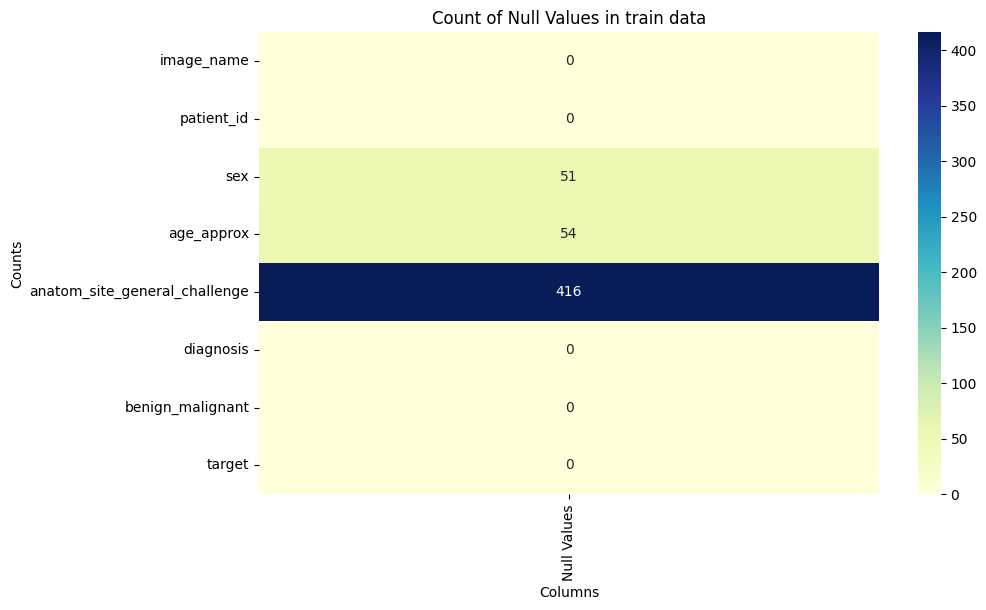

In [13]:
plot_missing(train_df,"train")

## Missing Values for Test Data

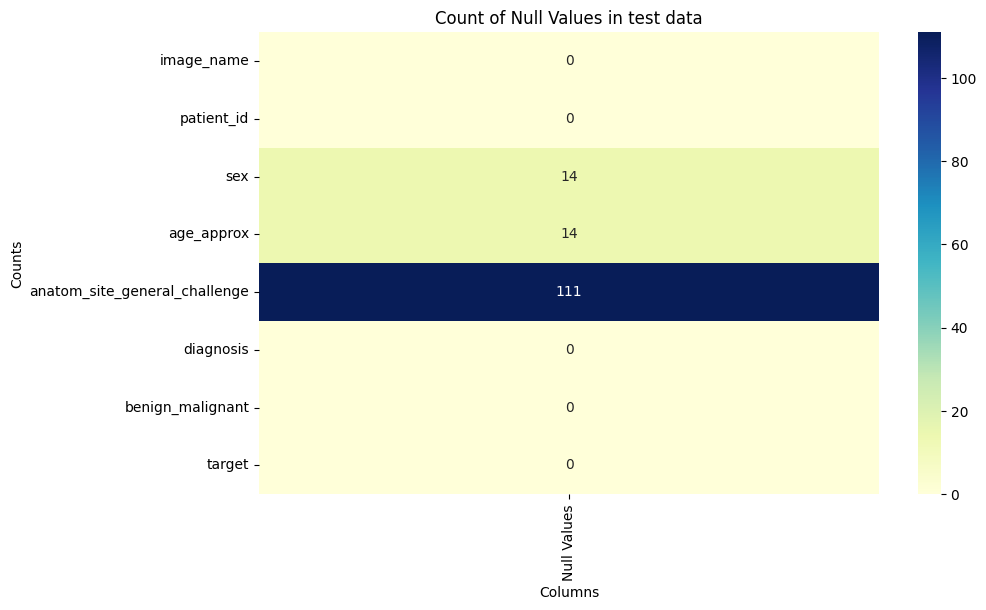

In [14]:
plot_missing(test_df,"test")

In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6626 entries, 0 to 6625
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     6626 non-null   object 
 1   patient_id                     6626 non-null   object 
 2   sex                            6612 non-null   object 
 3   age_approx                     6612 non-null   float64
 4   anatom_site_general_challenge  6515 non-null   object 
 5   diagnosis                      6626 non-null   object 
 6   benign_malignant               6626 non-null   object 
 7   target                         6626 non-null   int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 414.2+ KB


In [16]:
null_counts_train = train_df.groupby('target').apply(lambda x: x.isnull().sum())
null_counts_train

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
target,,,,,,,,
0,0,0,51,54,408,0,0,0
1,0,0,0,0,8,0,0,0


In [17]:
null_counts_test = test_df.groupby('target').apply(lambda x: x.isnull().sum())
null_counts_test

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
target,,,,,,,,
0,0,0,14,14,110,0,0,0
1,0,0,0,0,1,0,0,0


From above we can see that in training data *sex*, _age_approx_ and _anatom_site_general_challenge_ have missing values and in test data _anatom_site_general_challenge_ has missing value. Since most of them belong to begning class lets drop them.

In [18]:
train_df = train_df.dropna()
test_df = test_df.dropna()

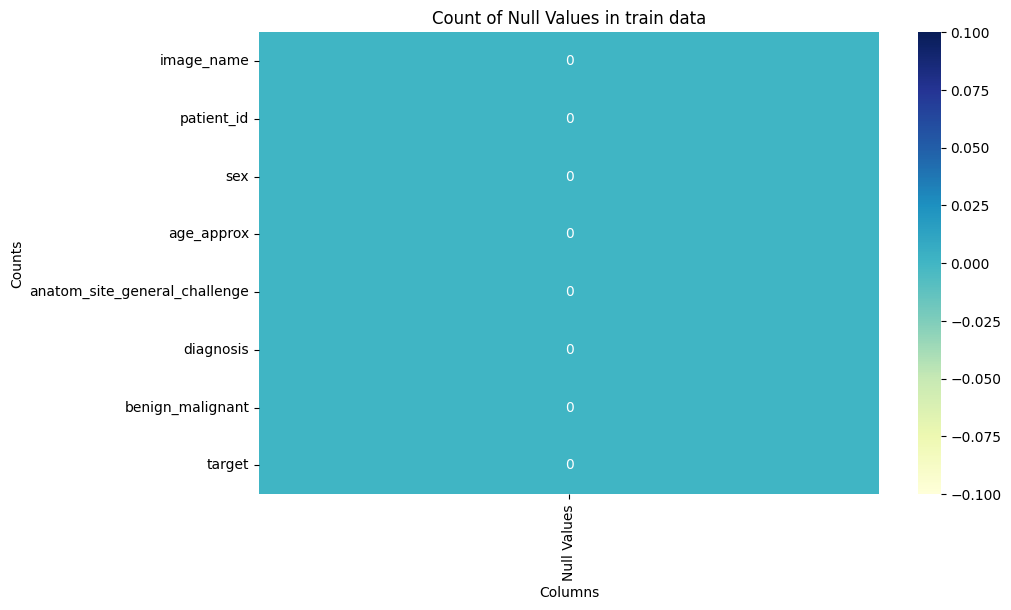

In [19]:
plot_missing(train_df,"train")

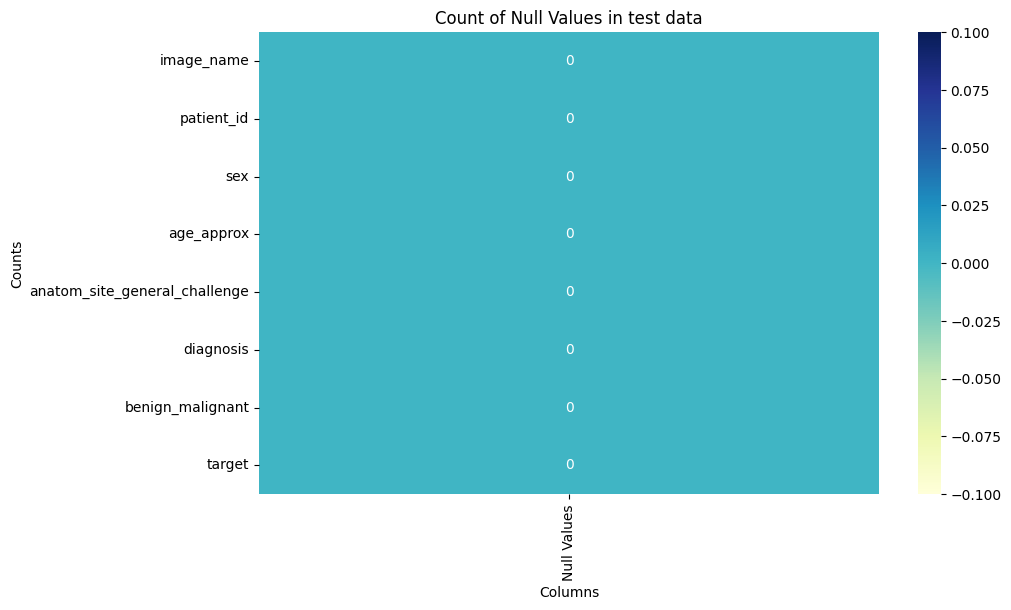

In [20]:
plot_missing(test_df,"test")

Lets Plot the Malignent vs Benign case

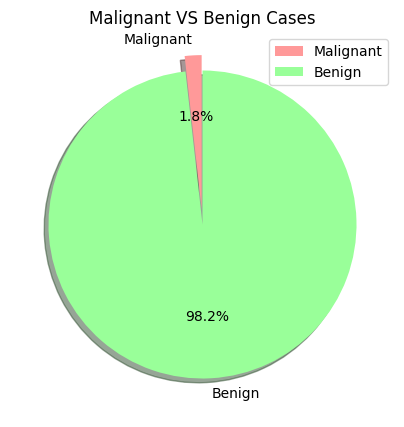

In [21]:
malignant = len(train_df[train_df["target"] == 1])
benign = len(train_df[train_df["target"] == 0])
colors = ['#ff9999','#99ff99']
labels = ["Malignant", "Benign"] 
size = [malignant, benign]

plt.figure(figsize = (5, 5))
plt.pie(size, labels = labels,explode=[0.1,0.0], shadow = True, startangle = 90, colors = colors,autopct='%1.1f%%')
plt.title("Malignant VS Benign Cases")
plt.legend()

The data is imbalanced.

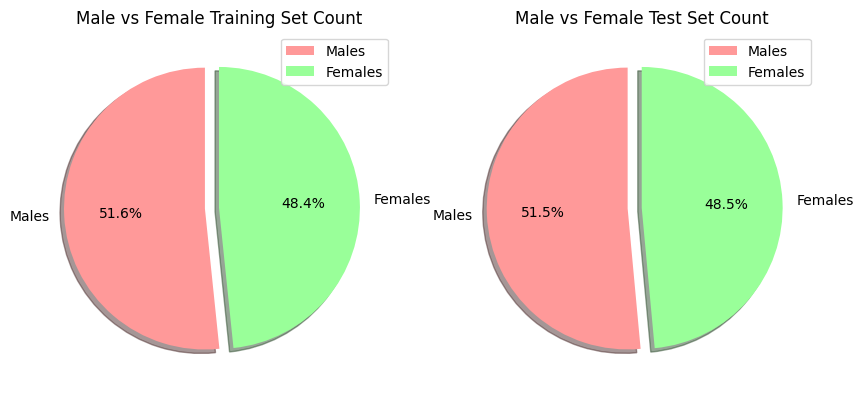

In [22]:
males_count_tr = len(train_df[train_df['sex']=='male'])
females_count_tr = len(train_df[train_df['sex']=="female"])

males_count_ts = len(test_df[test_df['sex']=='male'])
females_count_ts = len(test_df[test_df['sex']=="female"])

labels = ['Males', 'Females']
size = [males_count_tr, females_count_tr]
explode = [0.1, 0.0]

plt.figure(figsize= (10,10))
plt.subplot(1,2,1)
plt.pie(size, labels=labels, explode=explode, shadow=True, startangle=90, colors= colors, autopct='%1.1f%%')
plt.title('Male vs Female Training Set Count')
plt.legend()

size = [males_count_ts, females_count_ts]
plt.subplot(1,2,2)
plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, colors = colors, autopct='%1.1f%%')
plt.title("Male vs Female Test Set Count")
plt.legend()

## Benign and malignant by sex.

In [23]:
x = train_df.groupby(['benign_malignant', 'sex']).size()
x

benign_malignant  sex   
benign            female    12413
                  male      13158
malignant         female      175
                  male        284
dtype: int64

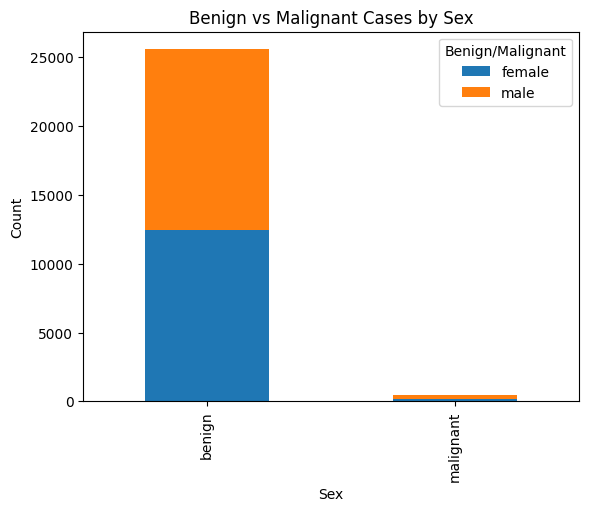

In [24]:
x.unstack().plot(kind='bar', stacked=True)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Benign vs Malignant Cases by Sex')
plt.legend(title='Benign/Malignant')
plt.show()

In [25]:
print("################### Training set info ###################")
print(train_df['anatom_site_general_challenge'].unique())
print(train_df['anatom_site_general_challenge'].value_counts())

print("\n\n")

print("################### Test set info ###################")
print(test_df['anatom_site_general_challenge'].unique())
print(test_df['anatom_site_general_challenge'].value_counts())

################### Training set info ###################
['torso' 'head/neck' 'upper extremity' 'lower extremity' 'palms/soles'
 'oral/genital']
anatom_site_general_challenge
torso              13423
lower extremity     6754
upper extremity     3970
head/neck           1477
palms/soles          298
oral/genital         108
Name: count, dtype: int64



################### Test set info ###################
['lower extremity' 'upper extremity' 'torso' 'palms/soles' 'head/neck'
 'oral/genital']
anatom_site_general_challenge
torso              3402
lower extremity    1645
upper extremity     993
head/neck           368
palms/soles          77
oral/genital         16
Name: count, dtype: int64


Let's plot the distribution for each columns in train data.

We can see that majority of the cases are observed at the torso, and after that the upper and lower extremities of the body  in both the training and testing set.

In [26]:
def plot_columns(df, column):
    value_counts = df[column].value_counts().sort_index()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values, palette="viridis", ax=ax1)
    ax1.set_xlabel(column, fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    for index, value in enumerate(value_counts.values):
        ax1.text(index, value + 0.1, str(value), ha='center', fontsize=10) 
    explode = [0.1 for i in range(len(value_counts))]
    ax2.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(value_counts)), explode=explode)
    ax2.axis('equal')
    fig.suptitle(f'Distribution in {column} column', fontsize=18)
    plt.tight_layout()
    plt.show()
    


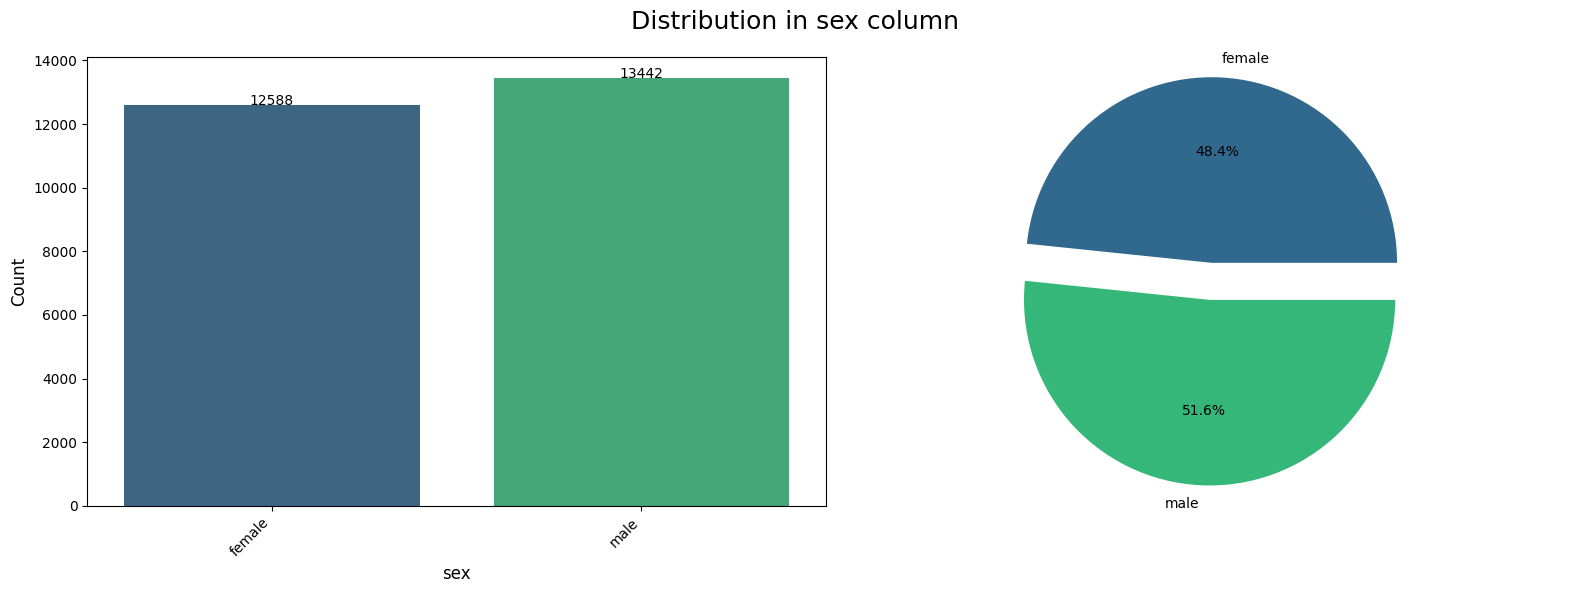

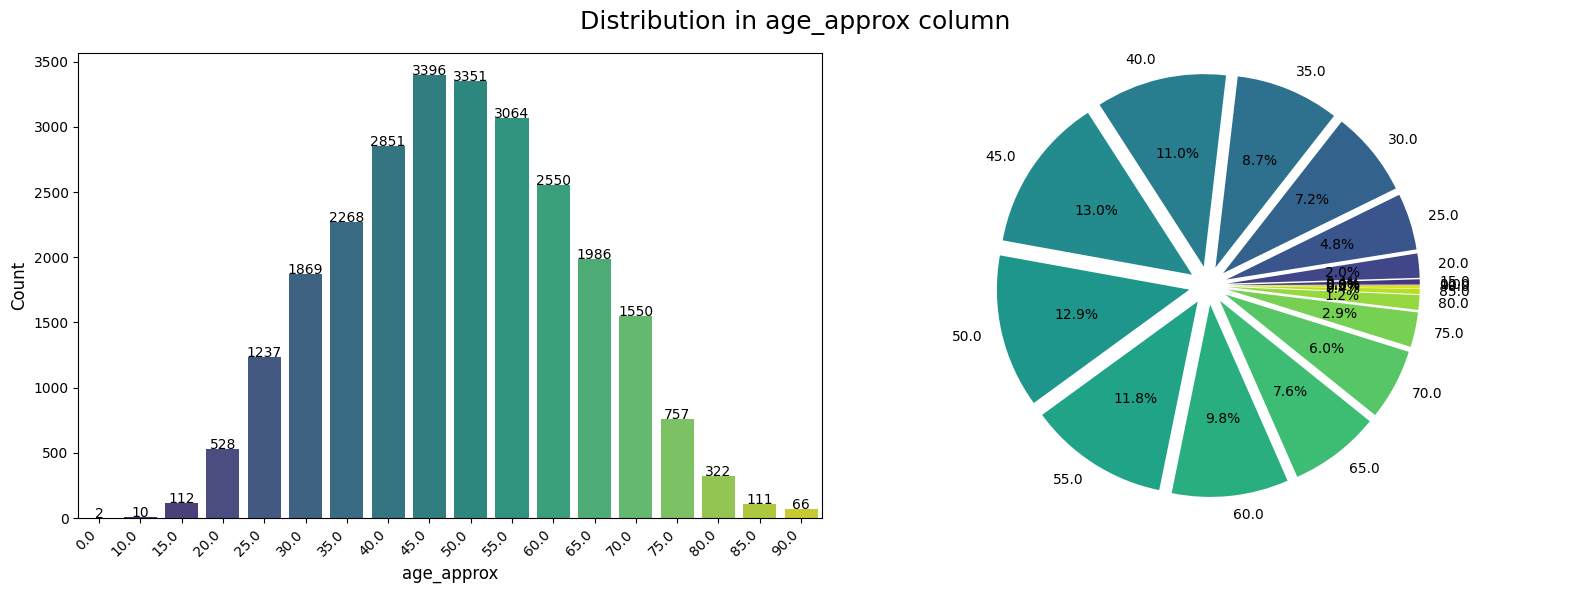

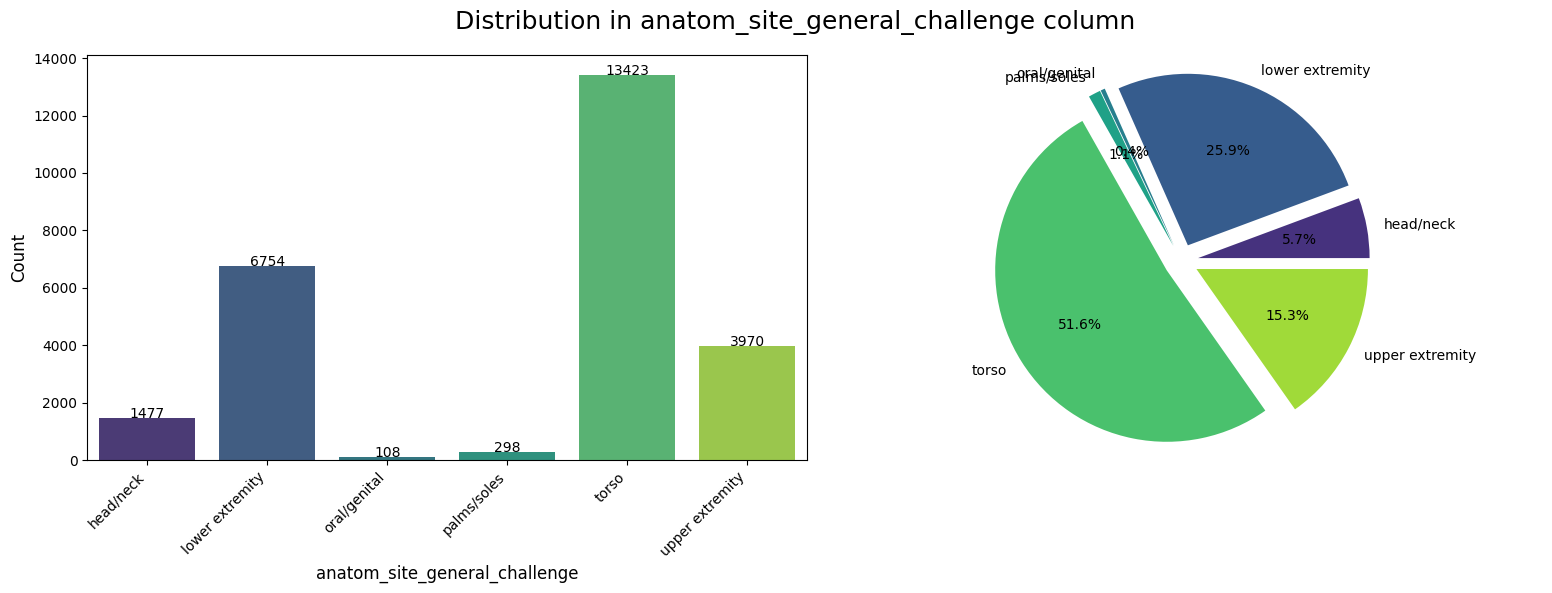

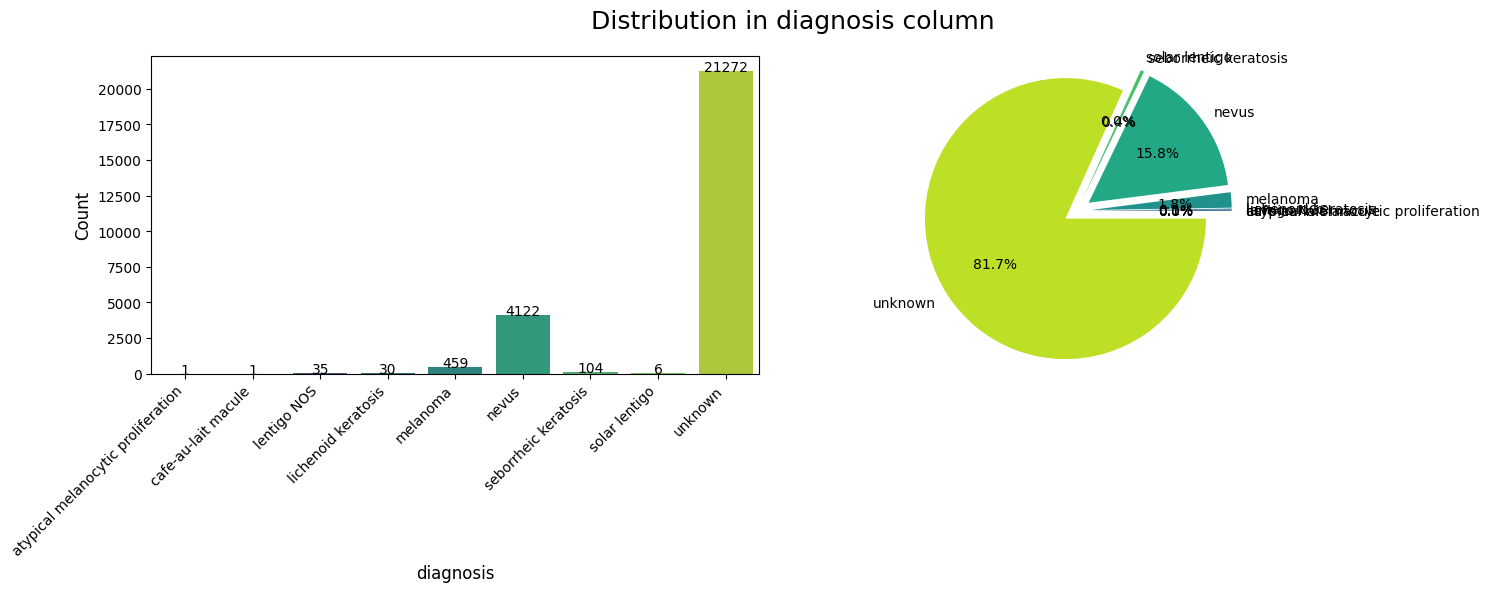

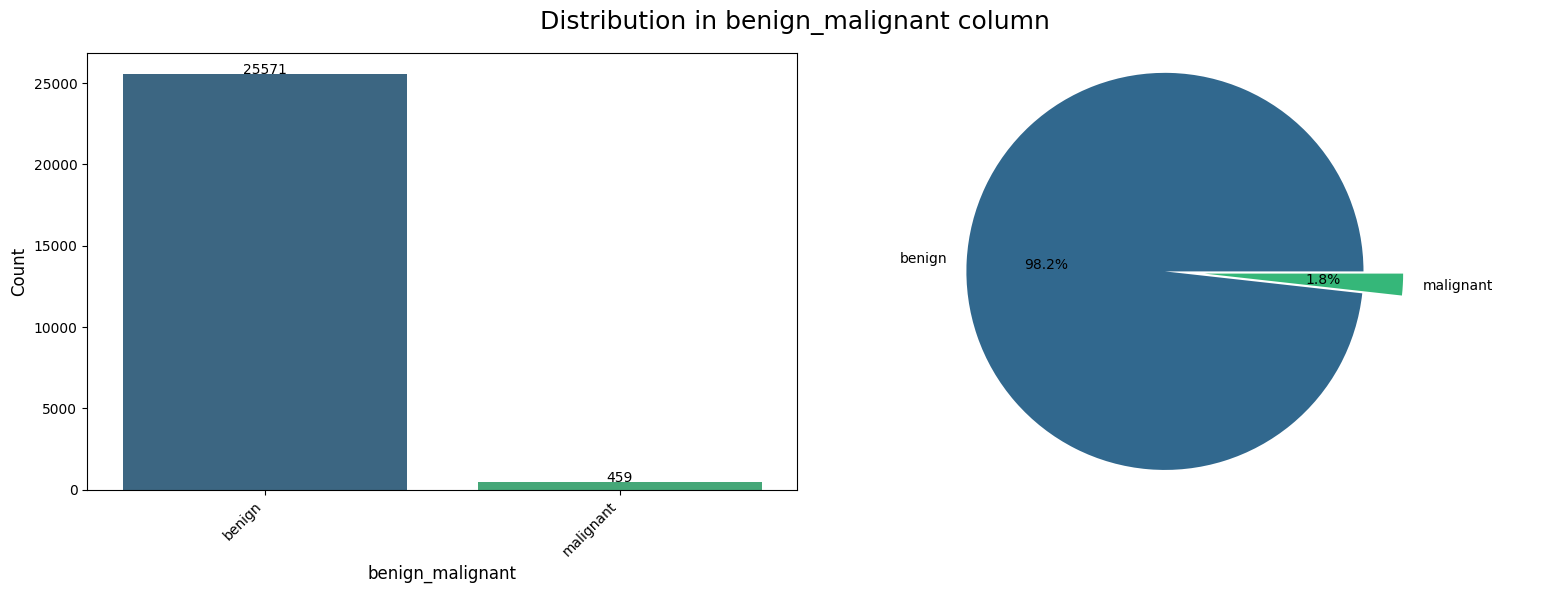

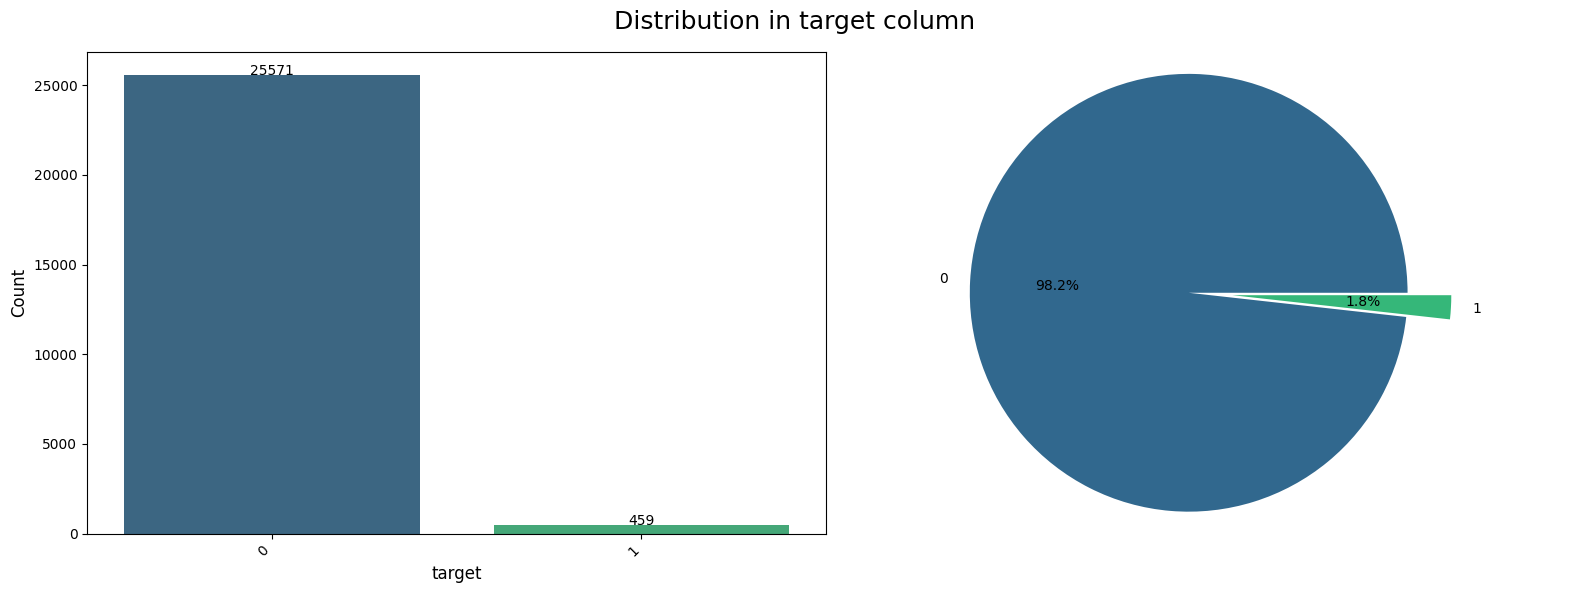

In [27]:
for column in train_df.columns:
    if column == 'image_name' or column =='patient_id':
        continue
    plot_columns(train_df, column)

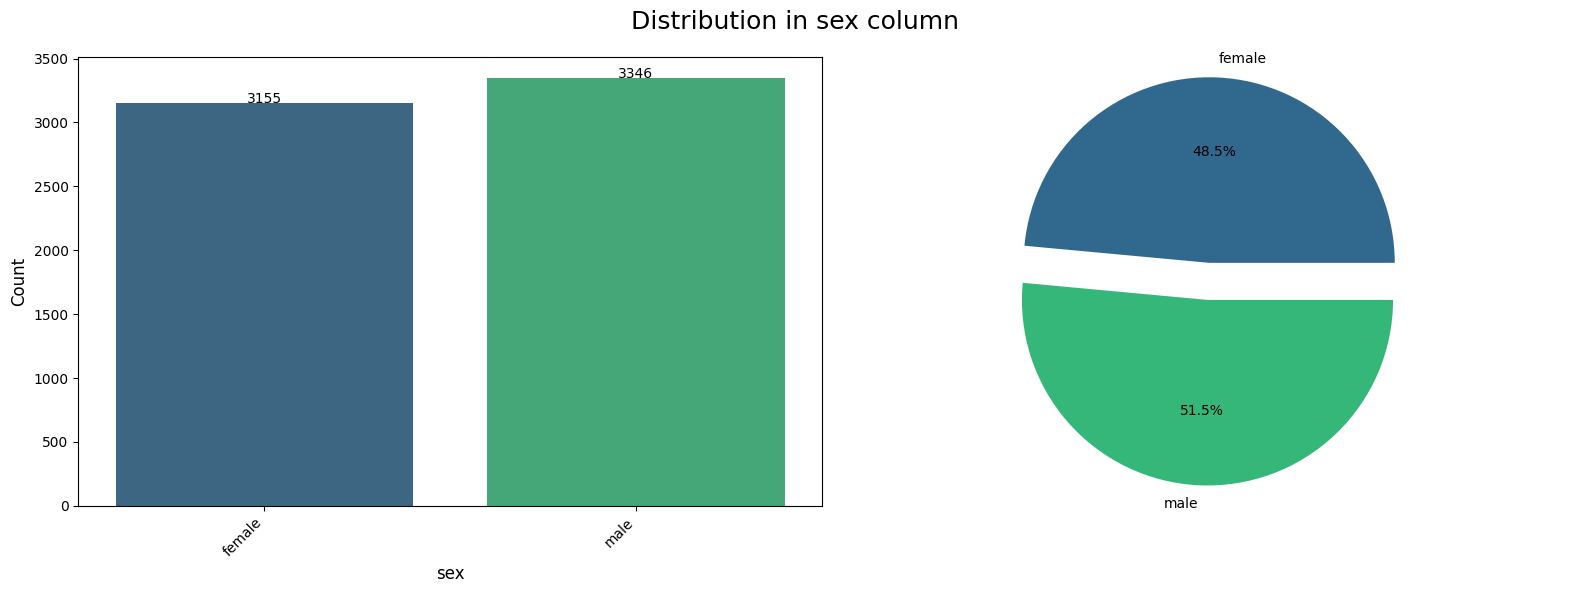

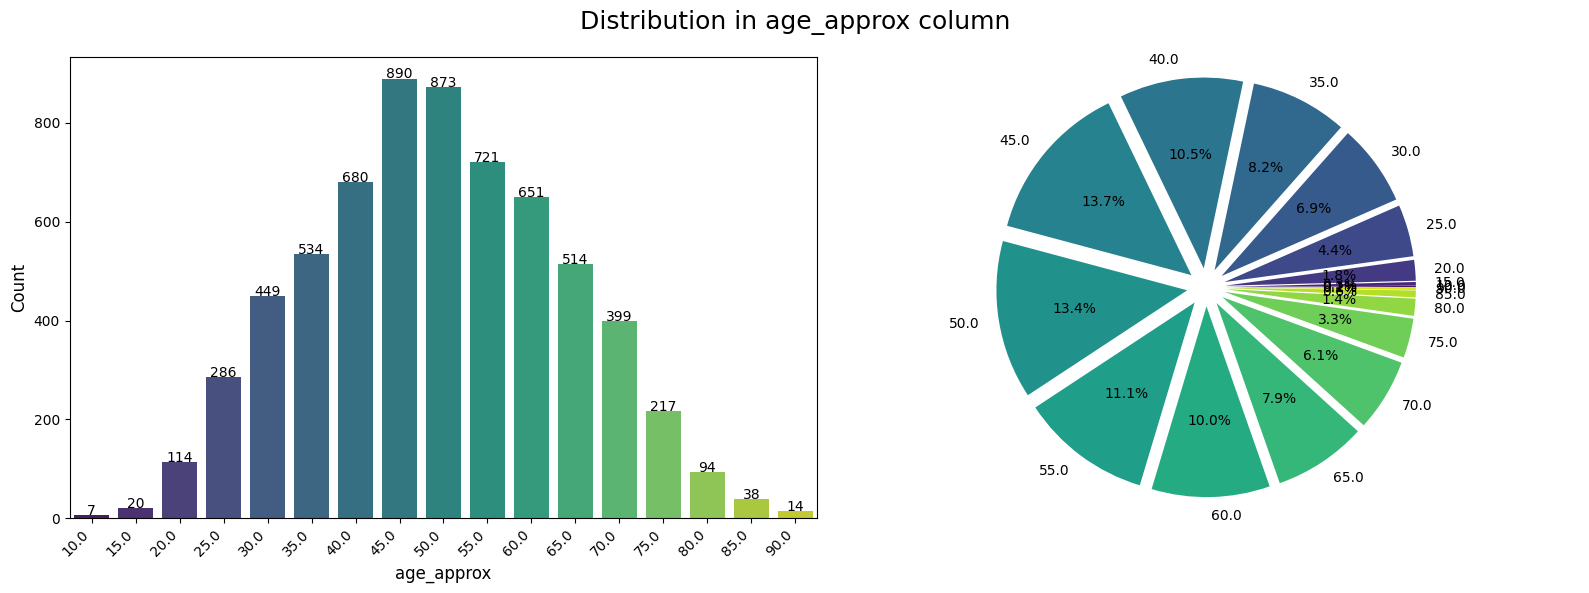

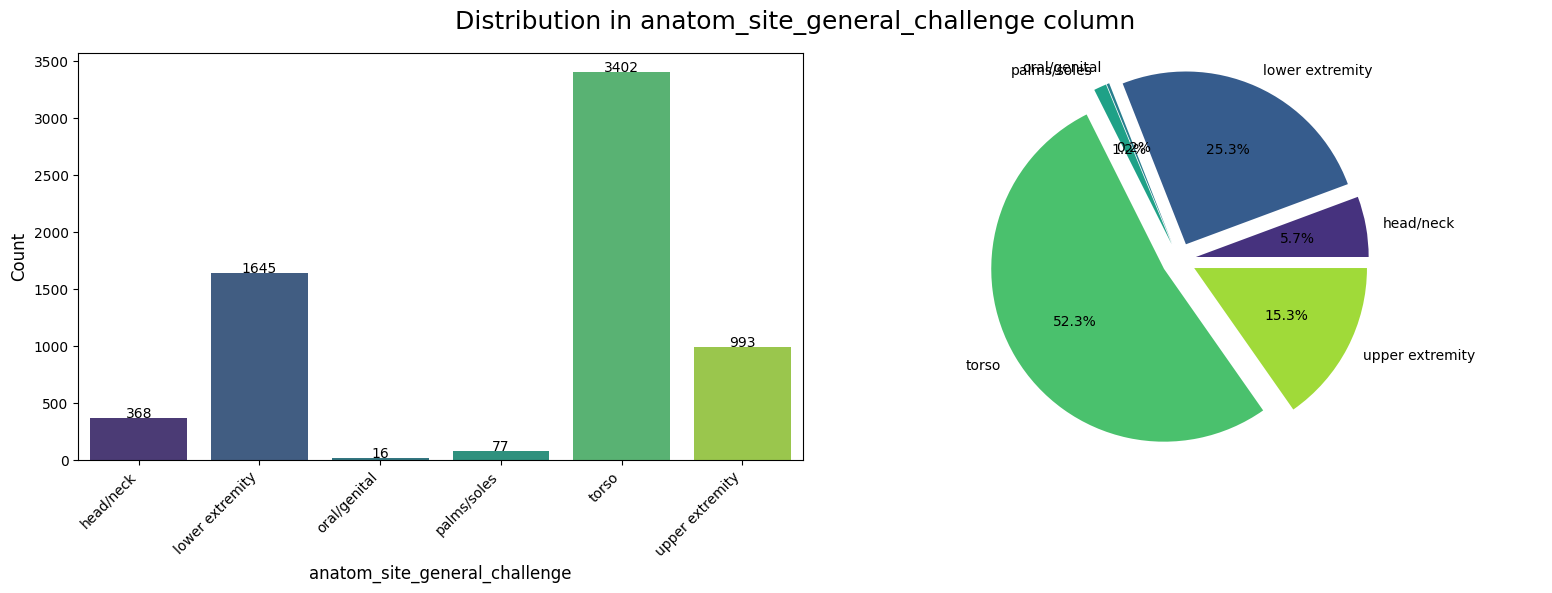

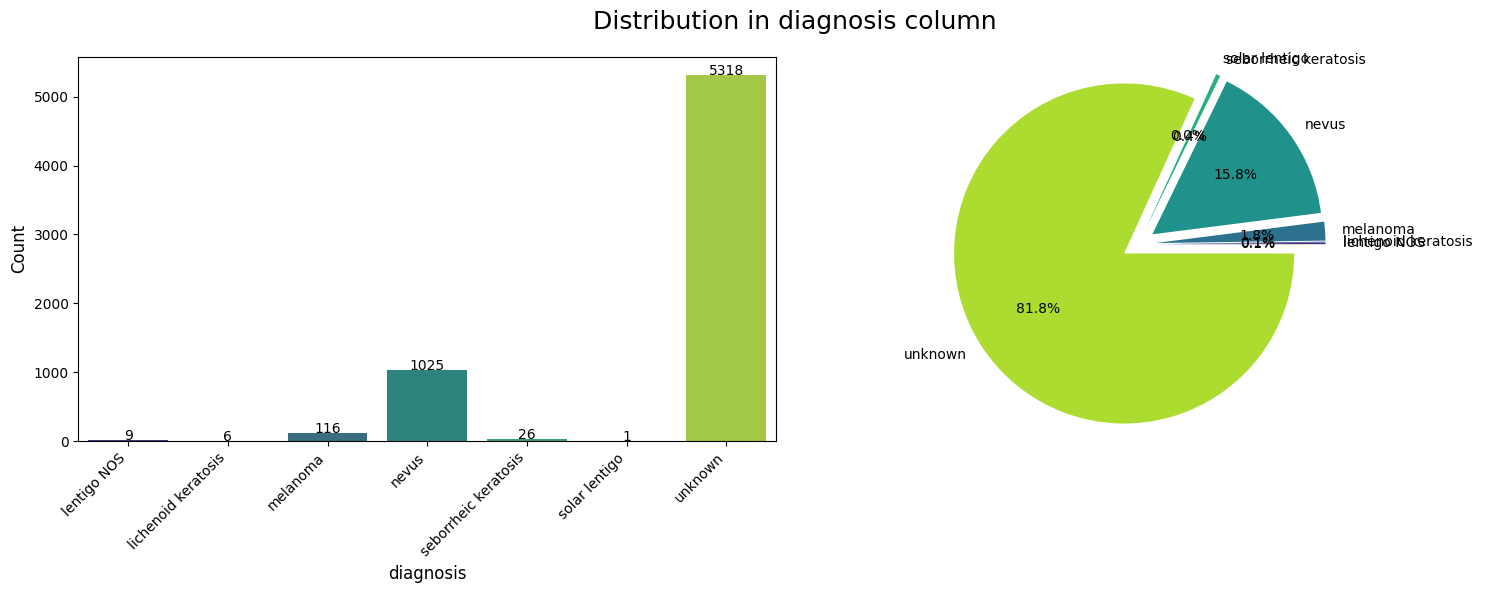

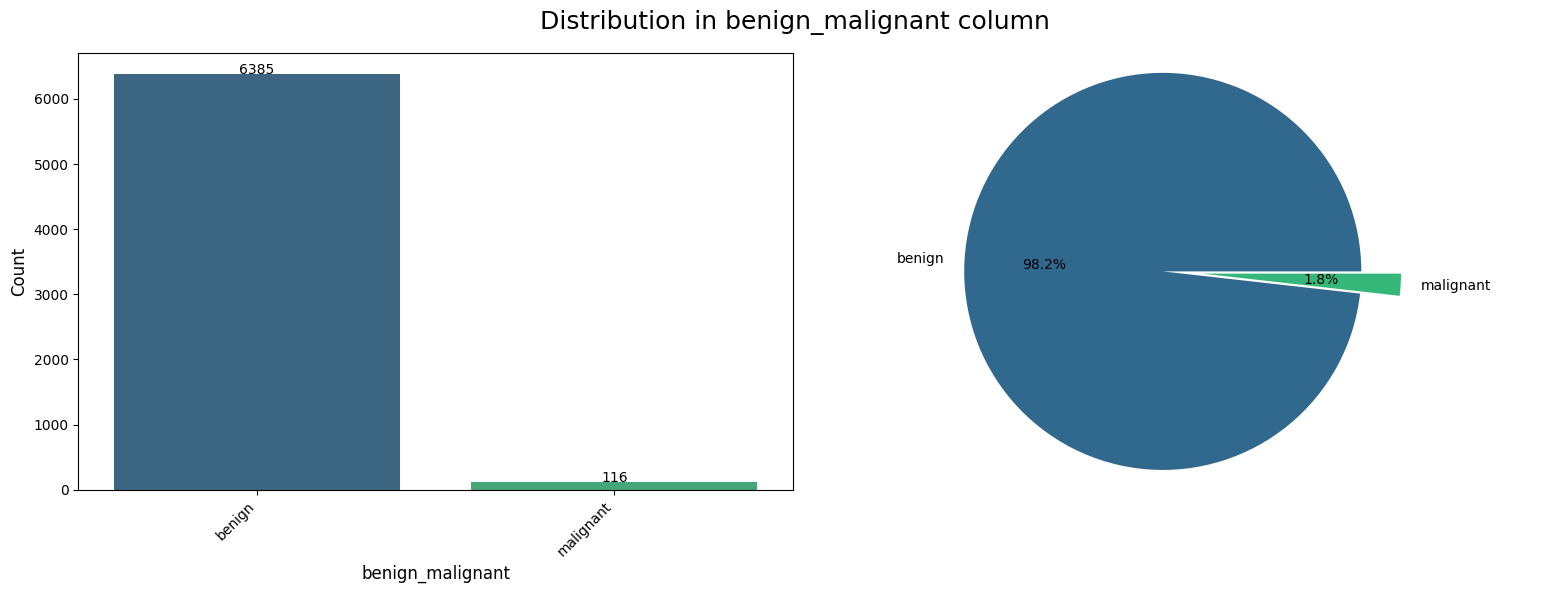

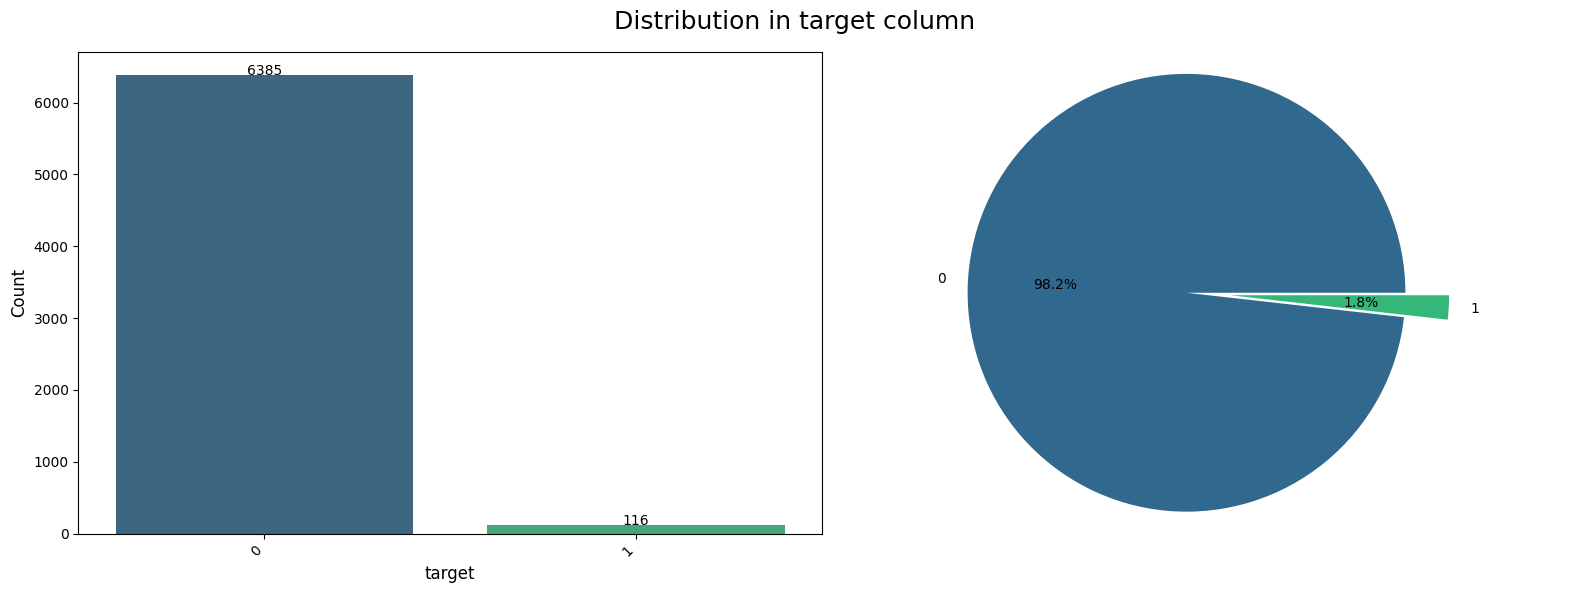

In [28]:
for column in test_df.columns:
    if column == 'image_name'or column =='patient_id':
        continue
    plot_columns(test_df, column)

Let's view some images from our data.

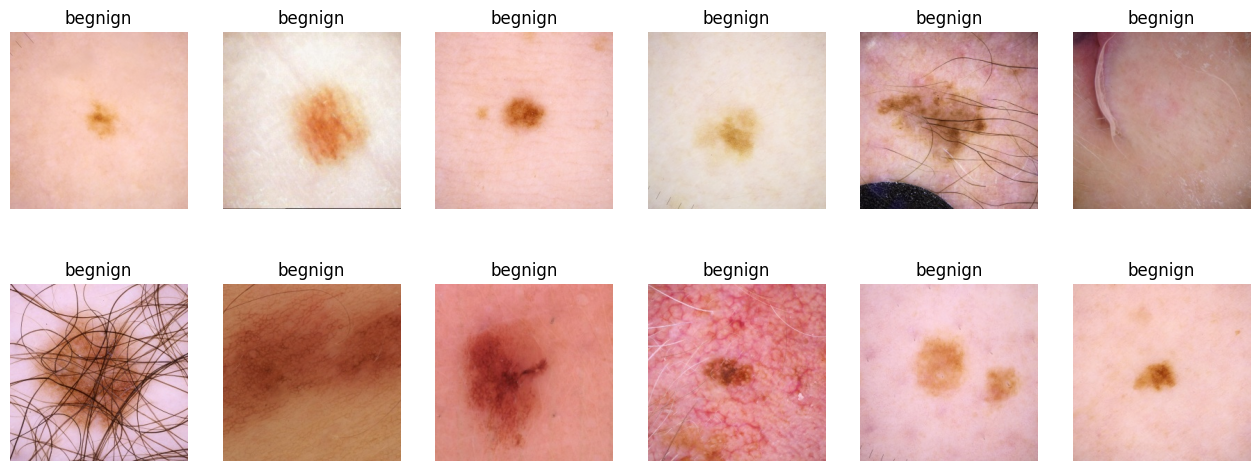

In [29]:
sample = train_df.sample(12).reset_index()
images = [sample['image_name'][i] +'.jpg' for i in range(12)]
labels = [sample['target'][i] for i in range(12)]
d_map  = {1:"malignent",0:"begnign"}
plt.figure(figsize = (16,6))
for i in range(12):
    plt.subplot(2,6, i+1)
    img = cv2.imread(os.path.join(train_dir, images[i]))
    img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title(d_map[labels[i]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    

## Lets Standardize and preprocess the data.

In [30]:
def drop_and_encode(df, type):
    to_drop = ['diagnosis', 'benign_malignant']
    for col in to_drop:
        if col in df.columns:
            df.drop([col], axis=1,inplace=True)
            
    to_encode = ['sex', 'anatom_site_general_challenge']
    encoded_all = []

    #Lets encode sex and anatom_site_general_challenge columns
    df[to_encode[0]] = df[to_encode[0]].astype(str)
    df[to_encode[1]] = df[to_encode[1]].astype(str)

    label_encoder = LabelEncoder()

    for col in to_encode:
        encoded = label_encoder.fit_transform(df[col])
        encoded_all.append(encoded)
        
    label_mappings = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print(f"Label_mappings for anatom_site_general_challenge:\n",label_mappings)
        
    df[to_encode[0]] = encoded_all[0]
    df[to_encode[1]] = encoded_all[1]
  
    #Add image path to the dataframe
    if type == "train":
        df['image_name'] = '/home/pukar/Pictures/skin-cancer/data/jpeg/train/' + train_df['image_name'] + '.jpg'
    if type == "test":    
        df['image_name'] = '/home/pukar/Pictures/skin-cancer/data/jpeg/train/' + test_df['image_name'] + '.jpg'




In [31]:
drop_and_encode(train_df,type="train")
drop_and_encode(test_df,type="test")

Label_mappings for anatom_site_general_challenge:
 {'head/neck': 0, 'lower extremity': 1, 'oral/genital': 2, 'palms/soles': 3, 'torso': 4, 'upper extremity': 5}
Label_mappings for anatom_site_general_challenge:
 {'head/neck': 0, 'lower extremity': 1, 'oral/genital': 2, 'palms/soles': 3, 'torso': 4, 'upper extremity': 5}


In [32]:
#Lets remane some columns
train_df = train_df.rename(columns={'age_approx': 'age', 'anatom_site_general_challenge': 'anatomy'})
test_df = test_df.rename(columns={'age_approx': 'age', 'anatom_site_general_challenge': 'anatomy'})

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df.head()

,image_name,patient_id,sex,age,anatomy,target
0,/home/pukar/Pictures/skin-cancer/data/jpeg/tra...,IP_7207550,1,55.0,4,0
1,/home/pukar/Pictures/skin-cancer/data/jpeg/tra...,IP_0894335,0,40.0,0,0
2,/home/pukar/Pictures/skin-cancer/data/jpeg/tra...,IP_2842809,0,55.0,4,0
3,/home/pukar/Pictures/skin-cancer/data/jpeg/tra...,IP_7279968,1,45.0,5,0
4,/home/pukar/Pictures/skin-cancer/data/jpeg/tra...,IP_5439716,1,70.0,4,0


In [33]:
#Normalize the columns
normalized_train = normalize(train_df[['sex', 'age', 'anatomy']])
normalized_test = normalize(test_df[['sex', 'age', 'anatomy']])

train_df['sex'] = normalized_train[:, 0]
train_df['age'] = normalized_train[:, 1]
train_df['anatomy'] = normalized_train[:, 2]

test_df['sex'] = normalized_test[:, 0]
test_df['age'] = normalized_test[:, 1]
test_df['anatomy'] = normalized_test[:, 2]


print('Len Train: {:,}'.format(len(train_df)), '\n' +
      'Len Test: {:,}'.format(len(test_df)))

Len Train: 26,030 
Len Test: 6,501


In [34]:
train_df['target'].value_counts()

target
0    25571
1      459
Name: count, dtype: int64

In [35]:
test_df['target'].value_counts()

target
0    6385
1     116
Name: count, dtype: int64


## Now Let's Create Custom Dataset Class and Data Loaders

In [36]:
feat_cols = ['sex', 'age', 'anatomy']
no_cols = 3
output_size = 1

In [37]:
class MelanomaDataset(Dataset):
    def __init__(self, dataframe, is_train=True,is_val=False, is_test=False):
        self.dataframe, self.is_train, self.is_valid, self.is_test = dataframe, is_train, is_val, is_test
        self.horizontal_flip = 0.5
        self.vertical_flip = 0.5
        if is_train or is_test:
            self.transform = Compose([RandomResizedCrop(height=224, width=224, scale=(0.4, 1.0)),
                                      ShiftScaleRotate(rotate_limit=90, scale_limit = [0.8, 1.2]),
                                      HorizontalFlip(p = self.horizontal_flip),
                                      VerticalFlip(p = self.vertical_flip),
                                      HueSaturationValue(sat_shift_limit=[0.7, 1.3], 
                                                         hue_shift_limit=[-0.1, 0.1]),
                                      RandomBrightnessContrast(brightness_limit=[0.7, 1.3],
                                                               contrast_limit= [0.7, 1.3]),
                                      Normalize(),
                                      ToTensorV2()])
        else:
            self.transform = Compose([
                                      Resize(224,224),
                                      Normalize(),
                                      ToTensorV2()])
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_pth = self.dataframe['image_name'][idx]
        image = cv2.imread(img_pth)
        col_features = np.array(self.dataframe.iloc[idx][['sex', 'age', 'anatomy']].values, dtype=np.float32)
        
        
        #Apply transforms
        image = self.transform(image = image)
        image = image['image']
    
        
        return image, col_features, self.dataframe['target'][idx]
    
    def get_labels(self):   return self.dataframe['target']  
        
        

In [38]:
def dataset_collate(batch):
    images = []
    col_features = []
    targets = []
    
    for image, col_feature, target in batch:
        images.append(image)
        col_features.append(col_feature)
        targets.append(target)
    print(images[0].shape)
    images = np.array(images)
    col_features = np.array(col_features)
    targets = np.array(targets)
    return images, col_features, targets





In [39]:
# Test Data and Loader and sampler
example_data = MelanomaDataset(train_df, is_train=False, is_val=True, is_test=False)
example_loader = torch.utils.data.DataLoader(example_data, batch_size = 5, sampler=ImbalancedDatasetSampler(example_data))


# Get a sample
for k, (images, csv_data,lab) in enumerate(example_loader):
        images = torch.tensor(images, device=device, dtype=torch.float32)
        csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)
        print(k,csv_data)
        print(images.shape)
        print(lab)
        break
        #valid_preds[k*images.shape[0] : k*images.shape[0] + images.shape[0]] 


0 tensor([[0.0181, 0.9972, 0.0725],
        [0.0154, 0.9980, 0.0614],
        [0.0249, 0.9947, 0.0995],
        [0.0000, 1.0000, 0.0000],
        [0.0133, 0.9985, 0.0533]], device='cuda:0')
torch.Size([5, 3, 224, 224])
tensor([1, 1, 0, 1, 1])


In [40]:
class MelanomaClassifier(nn.Module):
    def __init__(self, output_size, no_cols: int ):
        super(MelanomaClassifier, self).__init__()

        model_name = f"efficientnet-b2"
        
        #For image features
        self.cnn = EfficientNet.from_pretrained(model_name)
        
        #For col features
        self.cols = nn.Sequential(
            nn.Linear(no_cols, 250),
            nn.BatchNorm1d(250),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            
            nn.Linear(250, 250),
            nn.BatchNorm1d(250),
            nn.ReLU(),
            nn.Dropout(p=0.3)
            )
        #EfficientNet B2 outputs 1408 freatures, now lets change its FCN for classification
        self.classifier = nn.Sequential(nn.Linear(1408 + 250, output_size))   
        
    def forward(self, image, col_features):
        
        #Feed image to CNN to extract features
        image = self.cnn.extract_features(image)
        image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        
        #Feed col features to the FNN
        col_features = self.cols(col_features)
        
        #Combine two features
        combined_features = torch.cat((image, col_features), dim=1)
        
        #Use classifier model
        output = self.classifier(combined_features)
                                 
        return output


In [41]:
M= MelanomaClassifier(output_size=output_size, no_cols=no_cols)
M

Loaded pretrained weights for efficientnet-b2


MelanomaClassifier(
  (cnn): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadd

In [42]:
train_len = len(train_df)
test_len = len(test_df)

epochs = 30
patience = 4
TTA = 5
k = 6

weight_decay = 0.0
num_workers = 2
learning_rate = 0.0001
lr_patience = 1            
lr_factor = 0.3            

batch_size = 32

oof = np.zeros(shape = (train_len, 1))
print('Out of Fold shape:', oof.shape, '\n')

group_fold = GroupKFold(n_splits = k)

# Generate index to split data into training and test set.
folds = group_fold.split(X = np.zeros(train_len), y = train_df['target'], groups = train_df['patient_id'].tolist())



Out of Fold shape: (26030, 1) 



In [43]:
def train_folds(model):
    # Log file
    f = open(f"logs.txt", "w+")
    
    results = []
    for fold, (train_index, valid_index) in enumerate(folds):
        with open(f"logs.txt", 'a+') as f:
            print('-'*10, 'Fold:', fold+1, '-'*10, file=f)
        print('-'*10, 'Fold:', fold+1, '-'*10)


        
        # Best ROC score in this fold
        best_roc = None
        patience_f = patience
        
        # Reinitialize the model for every fold
        model = model

        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', 
                                      patience=lr_patience, verbose=True, factor=lr_factor)
        criterion = nn.BCEWithLogitsLoss()


        # Train and Valid Data
        train_data = train_df.iloc[train_index].reset_index(drop=True)
        valid_data = train_df.iloc[valid_index].reset_index(drop=True)

        # Create Data instances
        train = MelanomaDataset(train_data, is_train=True, is_val=False, is_test=False)
        valid = MelanomaDataset(valid_data, is_train=False, is_val=True, is_test=False)
        test = MelanomaDataset(test_df, is_train=False, is_val=False, is_test=True)

        # Create dataloder
        train_loader = DataLoader(train, batch_size=32, sampler=ImbalancedDatasetSampler(train), num_workers=num_workers)
        valid_loader = DataLoader(valid, batch_size=32, shuffle=False, num_workers=num_workers)
        test_loader = DataLoader(test, batch_size=16, shuffle=False, num_workers=num_workers)


        
        for epoch in range(epochs):
            start_time = timer()
            correct = 0
            train_losses = 0

            
            # Sets the model in training mode.
            model.train()

            for images, csv_data, labels in tqdm(train_loader,desc="Training"):
                
                images = torch.tensor(images, device=device, dtype=torch.float32)
                csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)
                labels = torch.tensor(labels, device=device, dtype=torch.float32)

               
                optimizer.zero_grad()
                out = model(images, csv_data)
                loss = criterion(out, labels.unsqueeze(1))
                loss.backward()
                optimizer.step()
                train_losses += loss.item()
                train_preds = torch.round(torch.sigmoid(out)) # 0 and 1
                correct += (train_preds.cpu() == labels.cpu().unsqueeze(1)).sum().item()

            # Compute Train Accuracy
            train_acc = correct / len(train_index)

            # Set the model in evaluation mode
            model.eval()

            # Create matrix to store evaluation predictions
            valid_preds = torch.zeros(size = (len(valid_index), 1), device=device, dtype=torch.float32)
            # Disables gradient tracking 
            with torch.inference_mode():
                for k, (images, csv_data, labels) in enumerate(tqdm(valid_loader,desc="Validation")):
                    images = torch.tensor(images, device=device, dtype=torch.float32)
                    csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)
                    labels = torch.tensor(labels, device=device, dtype=torch.float32)
                    out = model(images, csv_data)
                    pred = torch.sigmoid(out)
                    valid_preds[k*images.shape[0] : k*images.shape[0] + images.shape[0]] = pred

                # Compute accuracy and roc
                valid_acc = accuracy_score(valid_data['target'].values, torch.round(valid_preds.cpu()))
                valid_roc = roc_auc_score(valid_data['target'].values, valid_preds.cpu())

                # Compute time on Train + Eval
                duration = str(datetime.timedelta(seconds=timer() - start_time))[:7]


                # PRINT INFO
                # Append to file
                with open(f"logs.txt", 'a+') as f:
                    print('Time Taken:{} | Epoch: {}/{} | Loss: {:.4} | Train Acc: {:.3} | Valid Acc: {:.3} | ROC: {:.3}'.\
                     format(duration, epoch+1, epochs, train_losses, train_acc, valid_acc, valid_roc), file=f)
                # Print to console
                print('Time Taken:{} | Epoch: {}/{} | Loss: {:.4} | Train Acc: {:.3} | Valid Acc: {:.3} | ROC: {:.3}'.\
                     format(duration, epoch+1, epochs, train_losses, train_acc, valid_acc, valid_roc))


                
                # Update scheduler and save model
                scheduler.step(valid_roc)
                # Update best_roc
                if not best_roc: # If best_roc = None
                    best_roc = valid_roc
                    torch.save(model.state_dict(),
                               f"Fold{fold+1}_Epoch{epoch+1}_ValidAcc_{valid_acc:.3f}_ROC_{valid_roc:.3f}.pth")
                    continue
                if valid_roc > best_roc:
                    best_roc = valid_roc
                    # Reset patience 
                    patience_f = patience
                    torch.save(model.state_dict(),
                               f"Fold{fold+1}_Epoch{epoch+1}_ValidAcc_{valid_acc:.3f}_ROC_{valid_roc:.3f}.pth")
                else:
                    # Decrease patience 
                    patience_f = patience_f - 1
                    if patience_f == 0:
                        with open(f"logs.txt", 'a+') as f:
                            print('Early stopping | Best ROC: {}'.\
                                  format(best_roc), file=f)
                        print('Early stopping | Best ROC: {}'.\
                              format(best_roc))
                        break


        
        # Choose model with best r oc in this fold
        best_model_path = os.getcwd()+ os.sep+ [file for file in os.listdir(os.getcwd()) if str(round(best_roc, 3)) in file and 'Fold'+str(fold+1) in file][0]
        model = MelanomaClassifier(output_size = output_size, no_cols=no_cols).to(device)
        model.load_state_dict(torch.load(best_model_path))
        # Set the model in evaluation mode
        model.eval()


        with torch.inference_mode():
            # Predicting again on Validation data to get preds for out of fold
            valid_preds = torch.zeros(size = (len(valid_index), 1), device=device, dtype=torch.float32)

            for k, (images, csv_data, _) in enumerate(tqdm(valid_loader,desc="OOF Predictions")):
                images = torch.tensor(images, device=device, dtype=torch.float32)
                csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)
                out = model(images, csv_data)
                pred = torch.sigmoid(out)
                valid_preds[k*images.shape[0] : k*images.shape[0] + images.shape[0]] = pred

            # Save info to OOF
            oof[valid_index] = valid_preds.cpu().numpy()

            # Initialize variables to store metrics
            total_true_positive = 0
            total_true_negative = 0
            total_false_positive = 0
            total_false_negative = 0
            total_predictions = 0
            
            for i in range(TTA):
                for k, (images, csv_data, labels) in enumerate(tqdm(test_loader, desc="Testing")):
                    images = torch.tensor(images, device=device, dtype=torch.float32)
                    csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)
                    labels = torch.tensor(labels, device=device, dtype=torch.float32)
                    
                    out = model(images, csv_data)
                    test_preds = torch.round(torch.sigmoid(out))  # Convert logits to predictions
            
                   
                    preds = test_preds.cpu().numpy().flatten()  
                    true_labels = labels.cpu().numpy().flatten()  
                    
                    # Update confusion matrix
                    tn, fp, fn, tp = confusion_matrix(true_labels, preds, labels=[0, 1]).ravel()
                    total_true_positive += tp
                    total_true_negative += tn
                    total_false_positive += fp
                    total_false_negative += fn
                    
                    # Update total predictions count
                    total_predictions += len(preds)

            
            total_true_positive  = round(total_true_positive / TTA)
            total_true_negative  = round(total_true_negative / TTA)
            total_false_positive = round(total_false_positive / TTA)
            total_false_negative = round(total_false_negative / TTA)
            total_predictions = round(total_predictions / TTA)
            
            # Calculate metrics
            accuracy = (total_true_positive + total_true_negative) / total_predictions
            sensitivity = total_true_positive / (total_true_positive + total_false_negative)
            specificity = total_true_negative / (total_true_negative + total_false_positive)

            results.append({
                'Fold': fold+1,
                'Accuracy': accuracy,
                'True Positive': total_true_positive,
                'True Negative': total_true_negative,
                'False Positive': total_false_positive,
                'False Negative': total_false_negative,
                'Sensitivity': sensitivity,
                'Specificity': specificity
            })
        # Clear memory
        del train, valid, train_loader, valid_loader, images, labels
        # Garbage collector
        gc.collect()

    return results

In [44]:
model = MelanomaClassifier(output_size = output_size, no_cols=no_cols).to(device)
x=train_folds(model = model)


Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------


Validation: 100%|█████████████████████████████| 136/136 [00:05<00:00, 27.11it/s]


Time Taken:0:01:13 | Epoch: 1/30 | Loss: 400.3 | Train Acc: 0.66 | Valid Acc: 0.747 | ROC: 0.893


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.42it/s]


Time Taken:0:01:13 | Epoch: 2/30 | Loss: 372.7 | Train Acc: 0.691 | Valid Acc: 0.846 | ROC: 0.875


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 31.93it/s]


Time Taken:0:01:13 | Epoch: 3/30 | Loss: 355.8 | Train Acc: 0.711 | Valid Acc: 0.904 | ROC: 0.852


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.17it/s]


Time Taken:0:01:13 | Epoch: 4/30 | Loss: 338.4 | Train Acc: 0.729 | Valid Acc: 0.882 | ROC: 0.876


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 31.76it/s]


Time Taken:0:01:13 | Epoch: 5/30 | Loss: 328.9 | Train Acc: 0.736 | Valid Acc: 0.916 | ROC: 0.875
Early stopping | Best ROC: 0.8925800067703044
Loaded pretrained weights for efficientnet-b2


Testing: 100%|████████████████████████████████| 407/407 [00:07<00:00, 52.10it/s]


---------- Fold: 2 ----------


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 31.59it/s]


Time Taken:0:01:13 | Epoch: 1/30 | Loss: 370.3 | Train Acc: 0.696 | Valid Acc: 0.825 | ROC: 0.907


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.76it/s]


Time Taken:0:01:13 | Epoch: 2/30 | Loss: 355.7 | Train Acc: 0.712 | Valid Acc: 0.812 | ROC: 0.895


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 31.54it/s]


Time Taken:0:01:13 | Epoch: 3/30 | Loss: 342.1 | Train Acc: 0.728 | Valid Acc: 0.877 | ROC: 0.892


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.29it/s]


Time Taken:0:01:13 | Epoch: 4/30 | Loss: 325.6 | Train Acc: 0.741 | Valid Acc: 0.882 | ROC: 0.89


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.19it/s]


Time Taken:0:01:13 | Epoch: 5/30 | Loss: 317.6 | Train Acc: 0.744 | Valid Acc: 0.907 | ROC: 0.897
Early stopping | Best ROC: 0.9069548872180452
Loaded pretrained weights for efficientnet-b2


Testing: 100%|████████████████████████████████| 407/407 [00:07<00:00, 52.17it/s]


---------- Fold: 3 ----------


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 30.68it/s]


Time Taken:0:01:11 | Epoch: 1/30 | Loss: 356.5 | Train Acc: 0.716 | Valid Acc: 0.858 | ROC: 0.915


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.42it/s]


Time Taken:0:01:11 | Epoch: 2/30 | Loss: 342.0 | Train Acc: 0.729 | Valid Acc: 0.835 | ROC: 0.913


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.10it/s]


Time Taken:0:01:11 | Epoch: 3/30 | Loss: 329.1 | Train Acc: 0.74 | Valid Acc: 0.895 | ROC: 0.896


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.00it/s]


Time Taken:0:01:11 | Epoch: 4/30 | Loss: 315.1 | Train Acc: 0.749 | Valid Acc: 0.879 | ROC: 0.893


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.16it/s]


Time Taken:0:01:11 | Epoch: 5/30 | Loss: 303.0 | Train Acc: 0.757 | Valid Acc: 0.916 | ROC: 0.888
Early stopping | Best ROC: 0.9147576830608699
Loaded pretrained weights for efficientnet-b2


Testing: 100%|████████████████████████████████| 407/407 [00:07<00:00, 52.02it/s]


---------- Fold: 4 ----------


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.32it/s]


Time Taken:0:01:11 | Epoch: 1/30 | Loss: 349.0 | Train Acc: 0.723 | Valid Acc: 0.885 | ROC: 0.945


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.46it/s]


Time Taken:0:01:11 | Epoch: 2/30 | Loss: 332.4 | Train Acc: 0.74 | Valid Acc: 0.875 | ROC: 0.931


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.11it/s]


Time Taken:0:01:11 | Epoch: 3/30 | Loss: 327.7 | Train Acc: 0.742 | Valid Acc: 0.899 | ROC: 0.924


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 31.93it/s]


Time Taken:0:01:11 | Epoch: 4/30 | Loss: 312.7 | Train Acc: 0.751 | Valid Acc: 0.903 | ROC: 0.928


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 31.74it/s]


Time Taken:0:01:11 | Epoch: 5/30 | Loss: 303.6 | Train Acc: 0.763 | Valid Acc: 0.925 | ROC: 0.927
Early stopping | Best ROC: 0.9446110641055645
Loaded pretrained weights for efficientnet-b2


Testing: 100%|████████████████████████████████| 407/407 [00:07<00:00, 52.50it/s]


---------- Fold: 5 ----------


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.10it/s]


Time Taken:0:01:11 | Epoch: 1/30 | Loss: 332.1 | Train Acc: 0.733 | Valid Acc: 0.867 | ROC: 0.947


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.60it/s]


Time Taken:0:01:11 | Epoch: 2/30 | Loss: 326.1 | Train Acc: 0.739 | Valid Acc: 0.853 | ROC: 0.938


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.63it/s]


Time Taken:0:01:10 | Epoch: 3/30 | Loss: 319.2 | Train Acc: 0.745 | Valid Acc: 0.888 | ROC: 0.935


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.75it/s]


Time Taken:0:01:10 | Epoch: 4/30 | Loss: 300.7 | Train Acc: 0.759 | Valid Acc: 0.917 | ROC: 0.944


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.93it/s]


Time Taken:0:01:10 | Epoch: 5/30 | Loss: 292.8 | Train Acc: 0.767 | Valid Acc: 0.935 | ROC: 0.946
Early stopping | Best ROC: 0.9474052432444534
Loaded pretrained weights for efficientnet-b2


Testing: 100%|████████████████████████████████| 407/407 [00:07<00:00, 52.87it/s]


---------- Fold: 6 ----------


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.37it/s]


Time Taken:0:01:11 | Epoch: 1/30 | Loss: 323.9 | Train Acc: 0.748 | Valid Acc: 0.926 | ROC: 0.937


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.69it/s]


Time Taken:0:01:11 | Epoch: 2/30 | Loss: 310.8 | Train Acc: 0.755 | Valid Acc: 0.922 | ROC: 0.928


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.61it/s]


Time Taken:0:01:10 | Epoch: 3/30 | Loss: 305.1 | Train Acc: 0.757 | Valid Acc: 0.882 | ROC: 0.924


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.41it/s]


Time Taken:0:01:11 | Epoch: 4/30 | Loss: 291.5 | Train Acc: 0.771 | Valid Acc: 0.928 | ROC: 0.92


Validation: 100%|█████████████████████████████| 136/136 [00:04<00:00, 32.55it/s]


Time Taken:0:01:11 | Epoch: 5/30 | Loss: 280.8 | Train Acc: 0.778 | Valid Acc: 0.942 | ROC: 0.926
Early stopping | Best ROC: 0.9372480477663404
Loaded pretrained weights for efficientnet-b2


Testing: 100%|████████████████████████████████| 407/407 [00:07<00:00, 52.97it/s]


In [45]:
x =  pd.DataFrame(x)

In [46]:
x.mean(axis=0)

Fold                 3.500000
Accuracy             0.702277
True Positive       80.833333
True Negative     4484.666667
False Positive    1900.333333
False Negative      35.166667
Sensitivity          0.696839
Specificity          0.702375
dtype: float64

In [47]:
print('ROC: {:.3f}'.format(roc_auc_score(train_df['target'], oof)))
oof_1 = oof

ROC: 0.922


In [48]:
oof_1[oof_1 >= 0.5] = 1
oof_1[oof_1 < 0.5] = 0

In [49]:
oof

array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [50]:
oof_1

array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [51]:
print('Out of Fold Predictions:\n',confusion_matrix(train_df['target'], oof_1))

Out of Fold Predictions:
 [[21777  3794]
 [   68   391]]


In [52]:
print(classification_report(train_df['target'], oof_1))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92     25571
           1       0.09      0.85      0.17       459

    accuracy                           0.85     26030
   macro avg       0.55      0.85      0.54     26030
weighted avg       0.98      0.85      0.91     26030



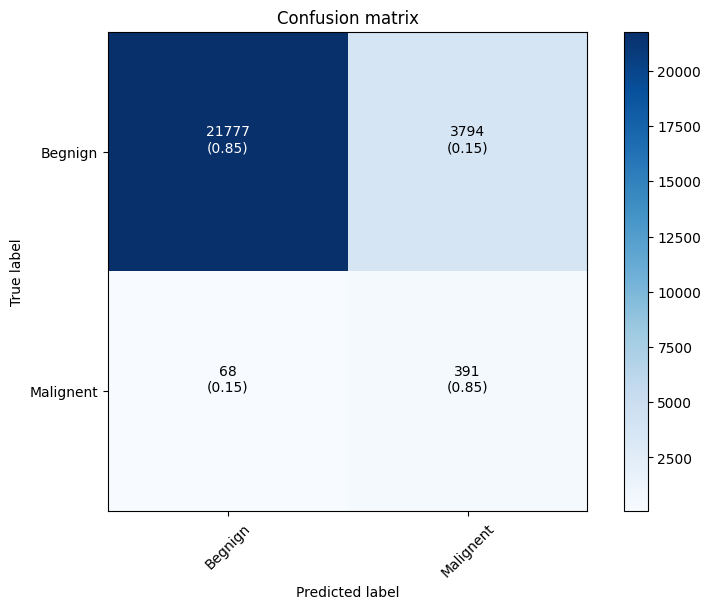

In [53]:
# Create Confusion Matrix
cm = confusion_matrix(train_df['target'], oof_1)

# Define class labels
classes = ['Begnign', 'Malignent']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Normalize confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd') + '\n(' + format(cm_norm[i, j], '.2f') + ')',
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()